In [14]:
using Revise
push!(LOAD_PATH,"../src/")
using ProgressBars
using Random
using ITensors,ITensorMPS
using PastaQ
using RandomMeas

In [63]:
#Perform RM in the first experiment
N = 8
ξ = siteinds("Qubit", N)

p,dp = 0.15,0.02
p_vec = [max(0, min(p + dp * randn(), 1)) for i in 1:N]
G = 1 .-p_vec/2

circuit = randomcircuit(N, depth=2)
states = ["Dn" for n in 1:N]
ψ0  = MPS(ComplexF64,ξ,states)

ρ0 = outer(ψ0',ψ0)
ρ0n = copy(ρ0)
Apply_depo_channel!(ρ0n,ξ,p_vec)

#
ρ = runcircuit(ρ0,circuit)
ρn = copy(ρ)
Apply_depo_channel!(ρn,ξ,p_vec)
#ρ = runcircuit(circuit;noise = noisemodel);
println("state prepared in the `experiment' 1 ")
#RM on a calibration state


nu=100 #Number of random unitaries
NM=10000 #Number of projective measurements per unitary
datat = zeros(Int8,(NM,N));
datat2 = zeros(Int8,(NM,N));

data = zeros(Int8,(nu,NM,N));

state prepared in the `experiment' 1 


In [64]:
#Calibration experiment
Gs = zeros(Float64,N)
for r in ProgressBar(1:nu, printing_delay=2)
        u = get_rotations(ξ,1) #Haar rotations in A
        get_RandomMeas!(datat,ρ0n,u)
        get_RandomMeas!(datat2,ρ0,u)
        σu = apply(u,ρ0,apply_dag=true)
        #σu = rotate(ρ0,u)
        for i in 1:N
            P = get_Born_data_binary(datat[:,i:i],ξ[i:i])
            #P2 = get_Born_data_binary(datat2[:,i:i],ξ[i:i])
            #@show norm(P-P2)
            σui,ξi = reduce_dm(σu,collect(i:i))
            Pσ = get_Born(σui)
            Gs[i] += real((3*(P-Pσ)*Pσ)[]+1)/nu
            #Gs[i] += real((3*(P-Pσ)*Pσ)[]+1)/nu
        end
end
println(G)
println(Gs)

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
93.0%┣█████████████████████████████████████████   ┫ 93/100 [00:02<00:00, 45it/s]


[0.9328429717258511, 0.9200574702345824, 0.9264579156952832, 0.9389173046833525, 0.9282019839316402, 0.9122039227649432, 0.9237942264163428, 0.9213827165272719]
[0.935538263491173, 0.9231512658436415, 0.9207754758818315, 0.9417950951577939, 0.9192860522958881, 0.9266340555112378, 0.9186615024572056, 0.9153456475372445]


100.0%┣██████████████████████████████████████████┫ 100/100 [00:02<00:00, 46it/s]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:02<00:00, 46it/s]


In [66]:
u = Vector{Vector{ITensor}}()
for r in ProgressBar(1:nu, printing_delay=2)
            push!(u,get_rotations(ξ,1)) #generate random unitary
            get_RandomMeas!(datat,ρn,u[r]) #data acquisation in simulated quantum device
            data[r,:,:] = datat
end

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:01<00:00, 84it/s]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:01<00:00, 84it/s]


In [69]:
ITensors.disable_warn_order()
purity = zeros(Float64,N)
purity_nonmit = zeros(Float64,N)
purity_mit = zeros(Float64,N)

for NA in ProgressBar(1:N, printing_delay=2)
        purity[NA] = get_purity(ρ,collect(1:NA),ξ)
        uA = [ut[1:NA] for ut in u]
        purity_nonmit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA])
        purity_mit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA];G=Gs)

end

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
100.0%┣███████████████████████████████████████████████┫ 8/8 [00:05<00:00, 2it/s]
100.0%┣███████████████████████████████████████████████┫ 8/8 [00:05<00:00, 2it/s]


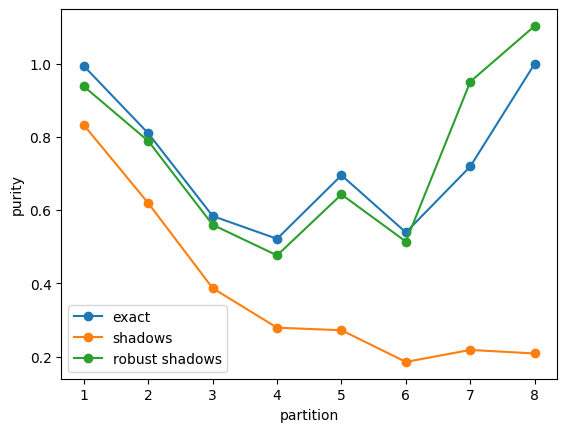

PyObject <matplotlib.legend.Legend object at 0x7f0279bd06d0>

In [70]:
using PyPlot
plot(1:N,purity,"-o")
plot(1:N,purity_nonmit,"-o")
plot(1:N,purity_mit,"-o")
xlabel("partition")
ylabel("purity")
legend(["exact","shadows","robust shadows"])